## Group Project
#### Andrew Long
#### William Jinkins
#### Tyler Borer

Our code is significantly different than any that we have seen on Kaggle, when dealing with these datasets. Unlike the previous code examples, we take the extra step of stemming and lemmatizing the data. Our goal is also slightly different, as well. We would like to not only predict if an article is fake or real, but we would also like to add additional classifications, such as propoganda.

This program will combine the two data sets. There are a total of 3 data sets. 
Overall program flow - 
* Load needed libraries
* Import the data and combine into single dataframe
* Clean data by removing duplicates, lower casing text, removing punctuation, removing stop words, stemming and lemmatizing, & removing numbers and special characters
* Examine the data and provide visualizations
* Data is then tokenized in 2 different ways


In [1]:
### Libraries Used

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import string
import gensim
import gensim.corpora as corpora
#!pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim import corpora, models
from gensim.models import CoherenceModel

### Importing Datasets and Combining Into One

In [2]:
### Importing first dataset and looking at top 5 rows
#Used the pandas read_csv function to import from folder "data"

df1 = pd.read_csv("data/Fake.csv")
df1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
### Importing second dataset and looking at top 5 rows
#Used the pandas read_csv function to import from folder "data"
df2 = pd.read_csv("data/True.csv")
df2.head()

### column names are the same as df1

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
### Importing third dataset and looking at top 5 rows
#Used the pandas read_csv function to import from folder "data"

df3 = pd.read_csv("data/fake_or_real_news.csv")
df3.head()

### column names are slightly different

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Note df1 and df2 have the same column names. df3 had different column names. 
If want to combine all three data frames, then will need to reduce df1 and df2 by dropping date and subject. The unnamed column in df3 will also need to be removed. 

In [5]:
print("The shape of Fake data is -",df1.shape)
print("The shape of True data is -",df2.shape)
print("The shape of the second combined data set is -",df3.shape)

The shape of Fake data is - (23481, 4)
The shape of True data is - (21417, 4)
The shape of the second combined data set is - (6335, 4)


Data Frame 3 is the cobmined data set which has true and fake data. It is a much smaller dataset. df1 and df2 are approximately the same size. This is important for our use so we are not solving a rare event model for prediction. 

In [6]:
### Assigning new label column to df1 and df2

label_fake = ["1"] * len(df1)
df1['label'] = label_fake
#print(df1.head())
label_real = ["0"] * len(df2)
df2['label'] = label_real
#print(df2.head())

### Changing 'label' column in df3 to binary values

df3['label'] = df3['label'].str.replace('FAKE', '1')
df3['label'] = df3['label'].str.replace('REAL', '0')
#df3.head()

In [7]:
### Combining df1 and df2

combined_df1_df2 = pd.concat([df1, df2], axis=0).reset_index(drop = True)
combined_df1_df2 = combined_df1_df2.drop(['subject', 'date'], axis= 1)
#combined_df1_df2.tail()
#print(combined_df1_df2.shape)

### Adding df3 to dataframe

news = pd.concat([combined_df1_df2, df3[df3.columns[1:]]]).reset_index(drop = True)
#news = df3[df3.columns[1:]]
news.tail(10)

,title,text,label
51223,Will the Media Reset After the Election or Are...,Written by Peter Van Buren venerable New Yor...,1
51224,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,1
51225,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,0
51226,Radio Derb Is On The Air–Leonardo And Brazil’s...,,1
51227,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,1
51228,State Department says it can't find emails fro...,The State Department told the Republican Natio...,0
51229,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
51230,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,1
51231,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",0
51232,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,0


In [8]:
#find the shape of the current news data frame
#this will be used to help determine number of duplicates
dirty = news.shape
print(dirty)

(51233, 3)


### Cleaning the data

In [9]:
### Removing duplicates
#This step is going to examine the text column and remove duplicates. 
#keeping only the first occurrence of each set of duplicates, and modifies the original df in place 
#resulting DataFrame will have a continuous index starting from 0

news.drop_duplicates(subset= ['text'], keep = 'first', inplace= True, ignore_index = True)
news.head(10)

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,1
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,1
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,1
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,1
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,1


In [10]:
cleaned=news.shape
print(cleaned)

(44705, 3)


In [11]:
#Check the data type of text and title column

news['title'].dtype


dtype('O')

In [12]:
news['text'].dtype

dtype('O')

In [13]:
#convert the title and text columns to strings
news['title'] = news['title'].astype(str)
news['text'] = news ['text'].astype(str)

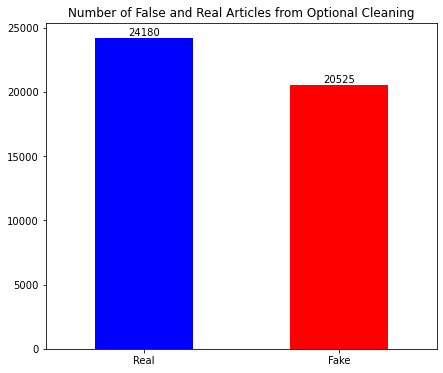

In [14]:
### Showing plot of the number of False or Real Articles
### We can see that there are more real than fake news articles in our data

ax= news['label'].value_counts().plot(kind= 'bar',
                                      rot= 0,
                                      figsize= (7, 6),
                                      title= 'Number of False and Real Articles from Optional Cleaning',
                                      color= ('b', 'r'))
ax.set_xticklabels(('Real', 'Fake'))

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show()

In [15]:
###

news_com = news.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.25)).reset_index(drop= True)
news_com.head(10)

,title,text,label
0,Gay and lesbian troops will be protected by ne...,WASHINGTON — Defense Secretary Ash Carter anno...,0
1,Puerto Rico governor hopes for 'open dialogue'...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,0
2,Backstory: Behind the terror takedown,When a U.S. special operations team suddenly s...,0
3,Myanmar jails foreign journalists with Turkish...,NAYPYITAW (Reuters) - A Myanmar court on Frida...,0
4,Republican Ryan is raising big money but not f...,WASHINGTON (Reuters) - Overlooked in all the s...,0
5,Rwandan president's challenger faces incitemen...,KIGALI (Reuters) - A prominent critic of Rwand...,0
6,"Losses, looting as Philippine war's fortunate ...","MARAWI CITY, Philippines (Reuters) - Khaliludd...",0
7,Brazilian minister quits in sign of rift in Te...,BRASILIA (Reuters) - One of four ministers rep...,0
8,Judge issues final order upholding Alabama sam...,(Reuters) - A federal judge in Alabama has iss...,0
9,"Saudi Arabia, Egypt to Invade Yemen",Egypt and Saudi Arabia are planning a ground o...,0


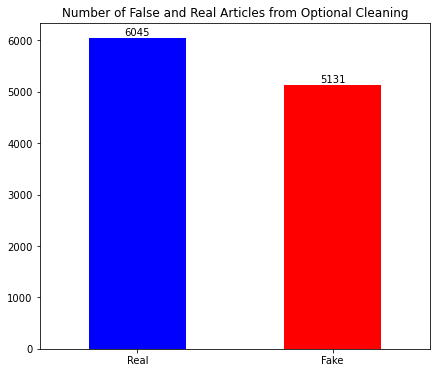

In [16]:
ax= news_com['label'].value_counts().plot(kind= 'bar',
                                      rot= 0,
                                      figsize= (7, 6),
                                      title= 'Number of False and Real Articles from Optional Cleaning',
                                      color= ('b', 'r'))
ax.set_xticklabels(('Real', 'Fake'))

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show()

There were approximately 6500 duplicated stories. The text was cleaned based on the body of the article. This indicates there was overlap between the two data sets and within the Truth and Fake data. Initially the data was split approximately 50/50. In the Data Exploration section the data will be examined to validate the mix between true and fake articles is still approximately 50/50.

#### The following cleaning steps optional. 
During final analysis, will determine if the additional cleaning helped build a stronger model. Each step can be operated independently or sequentially. Each cleaning step will have two variables. The first variable will pull from the previous cleaning step. The second variable will pull from the news set only. This direct change from the news dataframe will have the label '_only'. This will be used for comparison later. 
This cleaning will be applied to the text only. There is commented out steps if the user wants to apply changes to title column in data frame as well

In [17]:
###

ps = PorterStemmer()


def text_lowercase(text):
    return text.lower()

def split_hyphen(text):
    text = text.replace("-"," ")
    return text

def cleanup(text):
    for ele in text:
        text = re.sub(r"[^a-z]+", ' ', text)
    return text

def tokenize(text):
    text = word_tokenize(text)
    return text

def stemming(text):
    return(ps.stem(text))


def stopwords_removal(text):
    text = [word for word in text if not word in stopwords.words()]
    return text

def pre_processing(text):
    text = text_lowercase(text)
    text = cleanup(text)
    text = split_hyphen(text)
    text = stemming(text)


    text = stopwords_removal(text)
    
    return text

In [18]:
text_prep = []
for sentence in news_com['text']:
    text_prep.append(pre_processing(sentence))
news_com['text_prep']= text_prep

### Data Exploration

In [ ]:
### Looking at the shape of the news data

print("News combined shape", news_com.shape)

The two data frames are the same shape. This is expected since there were no additional row operations after removing duplicates. 

In [ ]:
### Looking at the basic information of both the news and combined news data

print("\nNews combined shape",news_com.info())

In [ ]:
### Using the describe function, we look at a quick description of the combined news data

news_com.describe()

In [ ]:
### We initially created a term frequency matrix by utilizing the CountVectorizer function
#This repeats the previous step with using the word_tokenize function
### We can see that the number of initial terms is 266,057

corpus = news_com.text_prep

vectorizer= CountVectorizer(tokenizer= word_tokenize)
tf_model= vectorizer.fit_transform(corpus)

len(vectorizer.vocabulary_)

The word tokenize function counts differently from the casual tokenizer. This is most apparent in the comparison of the two dirty values. Casual dirty - 244,731; Word dirty - 266,057. While with the clean data in both cases the tokenizer counted 193,750 in the vocabulary

In [ ]:
### When looking at the cleaned data word tokenizer shape of the term frequency matrix, 
#we see that the number of columns is 193,750
### and the number of rows is 44,705

tf_model.shape

In [ ]:
### Next, we created a term frequency matrix by utilizing the TfidfVectorizer function
### We can see that the number of initial terms is 244,730

vectorizer2= TfidfVectorizer(tokenizer= word_tokenize)
tfidf_model2= vectorizer2.fit_transform(corpus).toarray()

len(vectorizer2.vocabulary_)

In [ ]:
### Mean removal reduces noise in dataset
### We see that the number of columns is 244,730 and the number of rows is 44,705

tfidf_model2= pd.DataFrame(tfidf_model2)

tfidf_model2= tfidf_model2 - tfidf_model2.mean()

tfidf_model2.shape

#### The tf_model and the tfid_model have the same number of rows and columns - which is expected. We will likely primarily use the TF-ID, because of the weight of more/less frequent terms across documents.

##### We will also likely need to decrease the size of our dataset to create a subset of 10,000 rows (5,000 real and 5,000 fake), because we are getting a memory error on our school computers when we run the vectorizer functions.

In [ ]:
###

dictionary = gensim.corpora.Dictionary(news_com['text_prep'])

In [ ]:
###

bow_corpus = [dictionary.doc2bow(doc) for doc in news_com['text_prep']]
bow_corpus

In [ ]:
###

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
###

for doc in corpus_tfidf:
    print(doc)

In [ ]:
###

lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx+1, topic))

In [ ]:
### 

lda_model_bow.show_topic(0)

In [ ]:
###

for i in range(0,4):
  l = lda_model_bow.show_topic(i)
  print("\n\nTopic "+ str(i+1))  
  for i in range(len(l)):
    print(l[i][0])

In [ ]:
###

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

In [ ]:
###

for i in range(0,4):
  l = lda_model_tfidf.show_topic(i)
  print("\n\nTopic "+ str(i+1))  
  for i in range(len(l)):
    print(l[i][0])

In [ ]:
###

from gensim.models import CoherenceModel
print('Perplexity: ', round(lda_model_bow.log_perplexity(bow_corpus), 2))

coherence_model_lda = CoherenceModel(model=lda_model_bow, texts= 
                                     news_com['text_prep'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

In [ ]:
###

print('Perplexity: ', round(lda_model_tfidf.log_perplexity(corpus_tfidf), 2))
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts= news_com['text_prep'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

In [ ]:
###

def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=news_com['text_prep']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
###

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=news_com['text_prep'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

In [ ]:
###

vis = pyLDAvis.gensim.prepare(topic_model= lda_model_tfidf, 
                              corpus= corpus_tfidf, 
                              dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)